In [1]:
# https://youtu.be/nK-2k_ENgEc

import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
X = np.load('../data/X_quality.npy')
# y = np.array('./data/y_quality.npy')
y = pd.read_csv('../data/y_remap.csv').values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
print(f'x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}')
print(f'x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}')

FileNotFoundError: [Errno 2] No such file or directory: '../data/X_quality.npy'

In [5]:


###################################################################
# FEATURE EXTRACTOR function
# input shape is (n, x, y, c) - number of images, x, y, and channels
def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        input_img = x_train[image, :,:,:]
        img = input_img
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
    #Add feature extractors, e.g. edge detection, smoothing, etc. 
            
         # FEATURE 1 - Pixel values
         
        #Add pixel values to the data frame
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
        #df['Image_Name'] = image   #Capture image name as we read multiple images
        
        # FEATURE 2 - Bunch of Gabor filter responses
        
                #Generate Gabor features
        num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
        kernels = []
        for theta in range(2):   #Define number of thetas
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  #Sigma with 1 and 3
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
    #                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                # print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                
         
        # FEATURE 3 Sobel
        edge_sobel = sobel(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel1
       
        #Add more filters as needed
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset
####################################################################
#Extract features from training images
image_features = feature_extractor(x_train)
print(f'image_features.shape: {image_features.shape}')


image_features.shape: (243793920, 6)


In [6]:
#Reshape to a vector for Random Forest / SVM training
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_for_RF = np.reshape(image_features, (x_train.shape[0], -1))  #Reshape to #images, features

print(f'X_for_RF.shape: {X_for_RF.shape}')

X_for_RF.shape: (3720, 393216)


In [7]:

#Define the classifier
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)


#Can also use SVM but RF is faster and may be more accurate.
#from sklearn import svm
#SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
#SVM_model.fit(X_for_RF, y_train)


# Fit the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding


#Predict on Test data
#Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))

#Predict on test
test_prediction = RF_model.predict(test_for_RF)
#Inverse le transform to get original label back. 
# test_prediction = le.inverse_transform(test_prediction)
print(f'test_prediction.shape:{test_prediction.shape}')

/Users/mesmalif/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


test_prediction.shape:(931,)


Accuracy =  0.9087003222341569
The prediction for this image is:  [2]
The actual label for this image is:  [2]


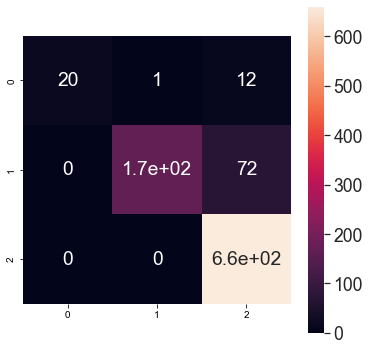

In [8]:

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, test_prediction))

#Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_prediction)

fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

#Check results on a few random images
import random
n=random.randint(0, x_test.shape[0]-1) #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)

#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_RF = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_prediction = RF_model.predict(input_img_for_RF)
# img_prediction = le.inverse_transform([img_prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_prediction)
print("The actual label for this image is: ", y_test[n])





In [9]:
pd.DataFrame(classification_report(y_test, test_prediction, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,0.994012,0.887097,0.9087,0.960370,0.918430
recall,0.606061,0.697479,1.000000,0.9087,0.767847,0.908700
f1-score,0.754717,0.819753,0.940171,0.9087,0.838214,0.902814
support,33.000000,238.000000,660.000000,0.9087,931.000000,931.000000
